In [4]:
import numpy as np
import sys
from pyinstrument import Profiler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from bart_playground import *
import bartz

In [5]:
proposal_probs = {"grow" : 0.5,
                  "prune" : 0.5}
generator = DataGenerator(n_samples=160, n_features=2, noise=0.1, random_seed=42)
X, y = generator.generate(scenario="piecewise_flat")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print(y_train)

[ 2.00327821  2.10672224  1.76898966  2.05211673  2.00693811  2.16162097
 -0.14127659  2.15112284  1.03487759  1.23276531  1.94055996  1.88216964
  2.08418201  2.04593858  2.08279882  1.87834399  0.83987221  1.96685118
  2.0928297   2.1475949   1.17439345  0.13206617  1.77087105  1.93949993
  1.98107557  1.97948383  2.09895839  1.96062588  2.13276861  2.05826552
  0.17207698  2.13535859  1.0856794   0.94290563  2.07019536  1.93288597
  1.84184056  2.00921267 -0.10137174  1.06375338  1.96419833  2.05241878
  2.05909063  1.01967761  0.88826159  1.79270166  0.03619219  2.0232878
  2.03139082  1.08443852  2.13095507  2.03043667  1.86178185  2.0803585
  1.81690942  1.00114261  1.97068084  2.10762402  1.91666312  2.03833939
  2.04389932  1.9154339   1.98689133  2.02703432  1.04138903  2.02762742
  1.92058637  1.00720336  2.10684716  0.9703429   2.0846584   2.16042544
  1.89594561  1.99308621  1.92953267  2.00543536  1.19510126  2.20769805
  2.02292114  1.00665458  0.91626018  0.98093489  1.9

In [6]:
# profiler = Profiler()
# profiler.start()
bart = DefaultBART(ndpost=80, nskip=40, n_trees=100, proposal_probs=proposal_probs)
bart.fit(X_train, y_train)
# profiler.stop()
# profiler.print()

Running iteration 0
Running iteration 10
Running iteration 20
Running iteration 30
Running iteration 40
Running iteration 50
Running iteration 60
Running iteration 70
Running iteration 80
Running iteration 90
Running iteration 100
Running iteration 110


In [7]:
arrays = [tree.vars for tree in bart.trace[-1].trees]
counts = np.array([np.count_nonzero(arr >= 0) for arr in arrays])
print(counts)
deep_trees = np.array([count >= 3 for count in counts])
print(np.where(deep_trees))

[1 2 1 1 1 1 1 1 1 0 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 2 3 1 1 1 1 1 1 1 1 0 2
 1 1 1 1 1 1 1 2 1 2 3 1 2 2 1 1 2 2 1 2 1 0 2 1 2 1 1 1 2 1 1 1 2 1 1 2 1
 1 2 1 1 2 1 1 2 1 1 1 2 2 1 1 3 1 1 2 1 2 1 1 1 1 1]
(array([26, 47, 89], dtype=int64),)


X_1 <= 0.306 (split, n = 120)
	X_1 <= 0.022 (split, n = 34)
		Val: 0.047 (leaf, n = 3)
		X_0 <= 0.779 (split, n = 31)
			Val: -0.036 (leaf, n = 24)
			Val: 0.002 (leaf, n = 7)
	Val: -0.009 (leaf, n = 86)
[ 1  1 -1 -1  0 -2 -2 -2 -2 -1 -1 -2 -2 -2 -2 -2]
[-0.02617894 -0.02351391 -0.00931974  0.04674322  0.00065444  0.02504832
  0.01267062 -0.03213583 -0.00239541 -0.03586712  0.00248064         nan
         nan         nan         nan         nan]


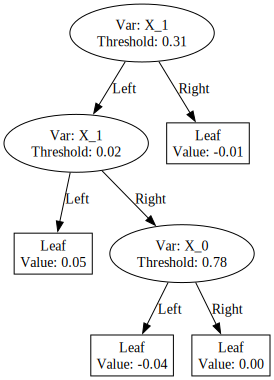

In [8]:
from bart_playground import visualize_tree
tree_sp : Tree = bart.sampler.trace[-1].trees[89]

print(tree_sp)
print(tree_sp.vars)
print(tree_sp.leaf_vals)
# print(tree_sp.node_indicators)
visualize_tree(tree_sp, tree_sp)

In [9]:
rf = RandomForestRegressor()
lr = LinearRegression()
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=100, ndpost=200, nskip=100)
btpred_all = btz.predict(np.transpose(X_test))
btpred = np.mean(np.array(btpred_all), axis=0)

Iteration 100/300 P_grow=0.56 P_prune=0.44 A_grow=0.30 A_prune=0.36 (burnin)
Iteration 200/300 P_grow=0.57 P_prune=0.43 A_grow=0.37 A_prune=0.49
Iteration 300/300 P_grow=0.57 P_prune=0.43 A_grow=0.37 A_prune=0.40


In [10]:
models = {"bart" : bart, 
          "rf" : rf, 
          "lr" : lr,
          "btz" : btz}
results = {}
for model_name, model in models.items():
    if model_name == "btz":
        results[model_name] = mean_squared_error(y_test, btpred)
    else:
        results[model_name] = mean_squared_error(y_test, model.predict(X_test))
results

{'bart': 0.6735858678111372,
 'rf': 0.03938249500649046,
 'lr': 0.16526245493311217,
 'btz': 0.05354455956502713}

In [11]:
bart.predict(X_test)
# print(y_test)
print(bart.sampler.trace[100].evaluate(X_test))
for i in range(100):
    mse_i = mean_squared_error(y_test, bart.trace[i].evaluate(X_test))
    # print(mse_i)

[-0.31660249 -0.04356154 -0.1556106  -0.23682531 -0.2513938  -0.04356154
  0.0283522  -0.35956926 -0.44997823 -0.30457432 -0.22178012 -0.35821457
 -0.45093644 -0.24962215 -0.07298025 -0.36266747 -0.11554057 -0.3492292
 -0.41504184 -0.30476714 -0.37629814 -0.33324875 -0.25043559 -0.29400108
 -0.32419395 -0.25818123 -0.19154561 -0.28193521 -0.03831298 -0.3317793
 -0.24245673 -0.24763193 -0.25986965 -0.3562974  -0.3187361  -0.38065556
 -0.34506239 -0.06661585 -0.12633102 -0.49960461]


In [12]:
mean_squared_error(y_test, np.ones_like(y_test) * y_test.mean())

0.39781114029234965

In [13]:
bart.sampler.trace[100].evaluate()

array([-59.32509938, -31.9810431 , -47.39034945, -32.63526896,
       -45.36054723, -56.58287772, -17.51323794, -62.65969159,
       -25.13475489, -31.71209509, -39.50960199, -56.21854938,
       -31.28038864, -34.45953416, -53.12406819, -58.11446396,
       -29.59395545, -61.1537194 , -37.53629771, -50.70804345,
       -29.84315698, -19.5681124 , -49.56032463, -40.91708657,
       -49.21069863, -57.49420324, -53.30319147, -54.8429206 ,
       -58.29713152, -54.64147953, -12.45732029, -49.40214805,
       -23.02008045, -25.33048554, -34.43248532, -40.15265063,
       -51.76438718, -34.81817318, -12.32270253, -42.4680233 ,
       -59.93692455, -59.79012593, -54.11784369, -23.92014188,
       -31.89141348, -40.97919379, -13.18989263, -34.73055789,
       -58.68001858, -25.62797741, -38.72165666, -49.06059687,
       -61.4027254 , -46.84652165, -50.38511243, -18.81193871,
       -46.03064126, -59.73245347, -42.92894927, -41.5300897 ,
       -39.43622567, -58.17879492, -37.81120203, -27.88